In [1]:
from chromatic_fitting import *

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


In [2]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pymc3 as pm
# import pymc3_ext as pmx
# import exoplanet as xo
# import os
# import starry
# from corner import corner

# np.random.seed(12)
starry.config.lazy = True
starry.config.quiet = True

In [3]:
# import theano
# theano.config.gcc__cxxflags += " -fexceptions"

In [4]:
hatp18b = Rainbow("/Users/catrionamurray/Documents/Postdoc/CUBoulder/JWST_data/*/*/jw02734-o001_t001_niriss_clear-gr700xd-substrip256/*.fits")

🌈🤖 This file contains data for 3 spectrosopic orders. Because no
`order=` keyword was supplied, we're defaulting to first order. You can
hide this warning by expliciting stating which order you want to load.
For this file, the options include [1 2 3].



  0%|          | 0/469 [00:00<?, ?it/s]

🌈🤖 The 2048 input wavelengths were not monotonically increasing.
<🌈(2048w, 469t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.



🌈🤖 The wavelength scale for this rainbow is '?',
and there are 2048 wavelength centers and
2048 wavelength edges defined.

It's hard to imshow something with a wavelength axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its wavelength edges defined. We're giving up
and just using the wavelength index as the wavelength axis.

If you want a real wavelength axis, one solution would
be to bin your wavelengths to a more uniform grid with
`rainbow.bin(R=...)` (for logarithmic wavelengths) or
`rainbow.bin(dw=...)` (for linear wavelengths)



<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength Index'>

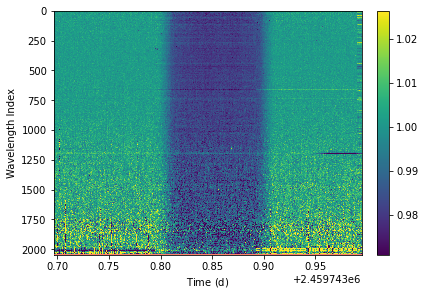

In [5]:
hatp18b = hatp18b.normalize()
hatp18b.imshow()

  0%|          | 0/469 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

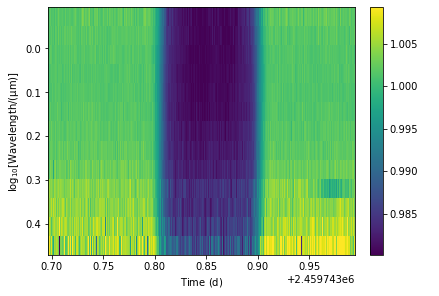

In [6]:
bin_hatp18b = hatp18b.bin(R=10)
bin_hatp18b.imshow()

  0%|          | 0/469 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

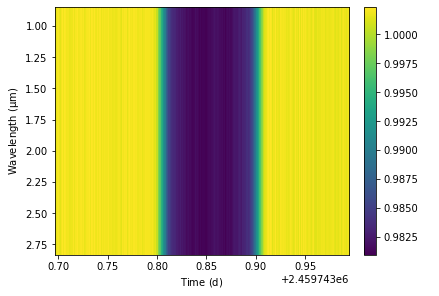

In [7]:
wlc_hatp18b = hatp18b.bin(nwavelengths=hatp18b.nwave)
wlc_hatp18b.imshow()

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

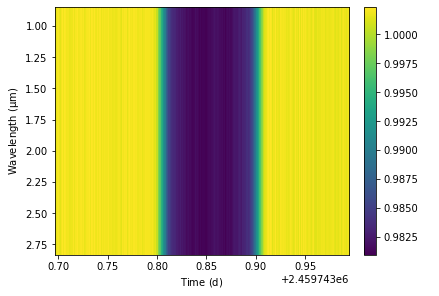

In [8]:
wlc_hatp18b.imshow()

In [9]:
bin_hatp18b.time

<Quantity [2459743.69672653, 2459743.6973623 , 2459743.69799807,
           2459743.69863384, 2459743.69926961, 2459743.69990538,
           2459743.70054115, 2459743.70117692, 2459743.70181269,
           2459743.70244846, 2459743.70308423, 2459743.70372   ,
           2459743.70435578, 2459743.70499155, 2459743.70562732,
           2459743.70626309, 2459743.70689886, 2459743.70753463,
           2459743.7081704 , 2459743.70880617, 2459743.70944194,
           2459743.71007771, 2459743.71071348, 2459743.71134925,
           2459743.71198503, 2459743.7126208 , 2459743.71325657,
           2459743.71389234, 2459743.71452811, 2459743.71516388,
           2459743.71579965, 2459743.71643542, 2459743.71707119,
           2459743.71770696, 2459743.71834273, 2459743.7189785 ,
           2459743.71961427, 2459743.72025005, 2459743.72088582,
           2459743.72152159, 2459743.72215736, 2459743.72279313,
           2459743.7234289 , 2459743.72406467, 2459743.72470044,
           2459743.725336

In [ ]:
star_temp = 4800 * u.K
logg = 4.58765 
metallicity = 0.0
distance = 161 * u.pc
radius = 0.7305 * u.Rsun

spot_temp = 3596 * u.K

# get the spectrum from the surface
_, surface_flux = get_phoenix_photons(
        temperature=u.Quantity(star_temp).value,
        logg=logg,
        metallicity=metallicity,
        wavelength=bin_hatp18b.wavelength,
    )

# get the received flux at Earth
received_flux = surface_flux * (radius / distance).decompose() ** 2

# get the spectrum from the surface
_, surface_flux_spot = get_phoenix_photons(
        temperature=u.Quantity(spot_temp).value,
        logg=logg,
        metallicity=metallicity,
        wavelength=bin_hatp18b.wavelength,
    )

# get the received flux at Earth
received_flux_spot = surface_flux_spot * (radius / distance).decompose() ** 2

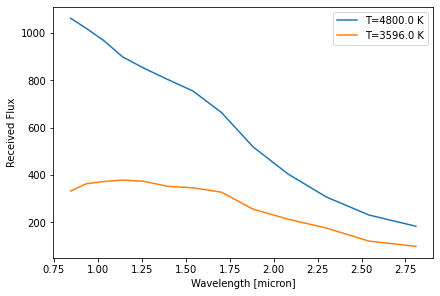

In [160]:
plt.plot(bin_hatp18b.wavelength, received_flux, label=f'T={star_temp}')
plt.plot(bin_hatp18b.wavelength, received_flux_spot, label=f'T={spot_temp}')
plt.ylabel("Received Flux")
plt.xlabel(f"Wavelength [{hatp18b.wavelength.unit}]")
plt.legend()

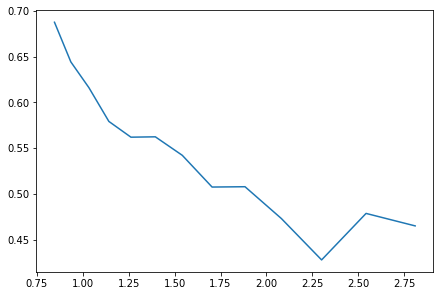

In [161]:
contrast = 1 - (received_flux_spot/received_flux)
plt.plot(bin_hatp18b.wavelength,contrast)

In [13]:
t= wlc_hatp18b.time.to_value('d')
flux = wlc_hatp18b.flux[0]
sigma = wlc_hatp18b.uncertainty[0]

In [14]:
# map = starry.Map(ydeg=5)
# map.add_spot(amp=-0.075, sigma=0.1, lat=0, lon=-30)
# A_y = np.array(map.y[1:])

hatp18_params = dict(
    ydeg=5,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=88.8,  # inclination in degrees
    amp=1.0,  # amplitude (a value prop. to luminosity)
    r=0.74,  #  radius in R_sun
    m=0.773,  # mass in M_sun
    prot=14.66,  # rotational period in days
    u=[0.10, 0.1],  # limb darkening coefficients
#     y=A_y,  # the spherical harmonic coefficients
)


In [15]:
with pm.Model() as model1:

    # Primary
    star_theory = starry.Primary(
        starry.Map(ydeg=hatp18_params["ydeg"], udeg=hatp18_params["udeg"], amp=hatp18_params['amp']),
        r=hatp18_params["r"],
        m=hatp18_params["m"],
        prot=hatp18_params["prot"],
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
    star_theory.map[1:] = hatp18_params["u"]
    
    star_theory.map.spot(contrast=0.6, radius=30, lat=0, lon=0)
    
    planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=62.610,  # mass in solar masses
    r=11.153,# radius
    inc=hatp18_params["inc"],
    length_unit=u.R_earth,
    mass_unit=u.M_earth,
    porb=5.508023,  # orbital period in days
    prot=5.508023,  # rotation period in days (synchronous)
    omega=120,  # longitude of ascending node in degrees
    ecc=0.084,  # eccentricity
#     w=120,  # longitude of pericenter in degrees
    t0=2459743.85,  # time of transit in days
    )

    # System
    sys = starry.System(star_theory, planet)

In [16]:
# sys.show(t)
# star.map.show(theta=np.linspace(0, 360, 50))

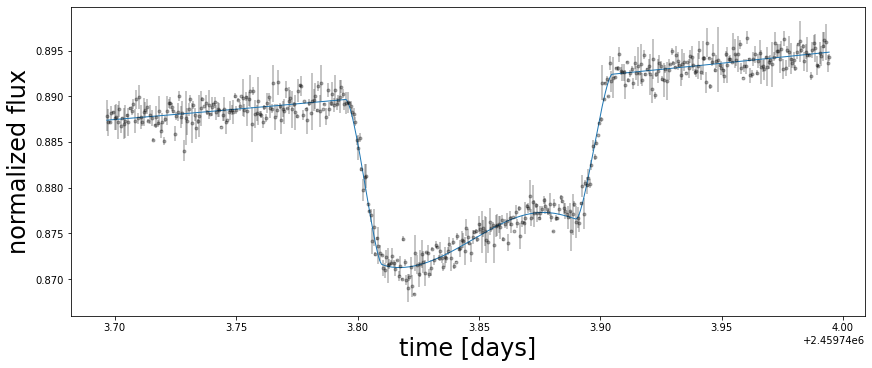

In [17]:
# t = np.linspace(-2.5, 2.5, 1000)
flux_true = eval_in_model(sys.flux(t), model=model1)
# flux_true = flux_true/np.nanmedian(flux_true)
# flux_true = eval_in_model(star.map.flux(theta=360*bin_hatp18b.time.to_value('d')/A["prot"]), model=model)
sigma = 0.001
flux = flux_true + sigma * np.random.randn(len(t))
ferr = sigma * np.random.randn(len(t))

fig, ax = plt.subplots(1, figsize=(12, 5))
# ax.plot(t, flux, "k.", alpha=0.3, ms=2)
plt.errorbar(t, flux, np.abs(ferr), c="k", fmt='.', alpha=0.3)
ax.plot(t, flux_true, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

🌈🤖 The wavelength scale for this rainbow is 'linear',
and there are 1 wavelength centers and
0 wavelength edges defined.

It's hard to imshow something with a wavelength axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its wavelength edges defined. We're giving up
and just using the wavelength index as the wavelength axis.

If you want a real wavelength axis, one solution would
be to bin your wavelengths to a more uniform grid with
`rainbow.bin(R=...)` (for logarithmic wavelengths) or
`rainbow.bin(dw=...)` (for linear wavelengths)



<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength Index'>

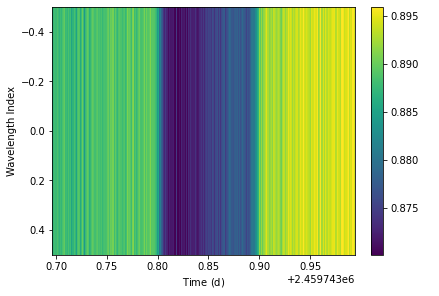

In [40]:
r = SimulatedRainbow(time=t*u.day, wavelength=wlc_hatp18b.wavelength)
r.flux = r.flux * flux
r.uncertainty[:] = np.abs(ferr)
r.imshow()

In [41]:
s = TransitSpotModel()
s.setup_parameters(
    # stellar parameters
    rs=hatp18_params["r"], # stellar radius in Sun radius
    ms=hatp18_params["m"], # stellar mass in Sun masses
    prot=hatp18_params["prot"], # stellar rotation period
    u=hatp18_params["u"], # limb-darkening coeffs
    
    # spot parameters
    spot_contrast = Fitted(Uniform,lower=0.0, upper=1.0, testval=0.7),
    spot_radius = Fitted(Uniform,lower=0.0, upper=180, testval=10.0),
    spot_latitude = Fitted(Normal, mu=0.0, sigma=10),
    spot_longitude = Fitted(Normal, mu=0.0, sigma=10),
    
    # planet parameters
    mp=62.610, # planet mass in Earth masses
    rp=11.153, # planet radius in Earth radii
    inc=hatp18_params["inc"],
    period=5.508023,  # orbital period in days
    omega=120,  # longitude of ascending node in degrees
    ecc=0.084,  # eccentricity
    t0=2459743.85,  # time of transit in days
)

In [42]:
s.summarize_parameters()

transitspot_A =
  <🧮 Fixed | 1 🧮>

transitspot_rs =
  <🧮 Fixed | 0.74 🧮>

transitspot_ms =
  <🧮 Fixed | 0.773 🧮>

transitspot_prot =
  <🧮 Fixed | 14.66 🧮>

transitspot_u =
  <🧮 Fixed | [0.1, 0.1] 🧮>

transitspot_spot_contrast =
  <🧮 Fitted Uniform(lower=0.0, upper=1.0, testval=0.7, name='transitspot_spot_contrast') 🧮>

transitspot_spot_radius =
  <🧮 Fitted Uniform(lower=0.0, upper=180, testval=10.0, name='transitspot_spot_radius') 🧮>

transitspot_spot_latitude =
  <🧮 Fitted Normal(mu=0.0, sigma=10, name='transitspot_spot_latitude') 🧮>

transitspot_spot_longitude =
  <🧮 Fitted Normal(mu=0.0, sigma=10, name='transitspot_spot_longitude') 🧮>

transitspot_mp =
  <🧮 Fixed | 62.61 🧮>

transitspot_rp =
  <🧮 Fixed | 11.153 🧮>

transitspot_inc =
  <🧮 Fixed | 88.8 🧮>

transitspot_period =
  <🧮 Fixed | 5.508023 🧮>

transitspot_omega =
  <🧮 Fixed | 120 🧮>

transitspot_ecc =
  <🧮 Fixed | 0.084 🧮>

transitspot_t0 =
  <🧮 Fixed | 2459743.85 🧮>



In [43]:
s.attach_data(r)

In [44]:
s.setup_lightcurves()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


In [45]:
s.setup_likelihood()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
optimizing logp for variables: [transitspot_spot_longitude, transitspot_spot_latitude, transitspot_spot_radius, transitspot_spot_contrast]


message: Optimization terminated successfully.
logp: -858496649.2927022 -> -35618.84736113432
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


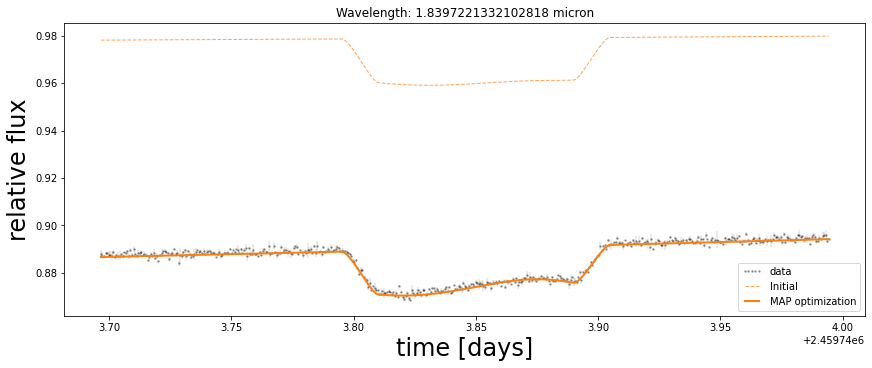

In [46]:
opt = s.optimize(plot=True)

In [ ]:
s.sample(start=opt, draws=1000, tune=1000)

Sampling model using the <function sample at 0x7f7c107efca0> method


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:729: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.trace = sampling_method(**sampling_kw, **kw)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/catrionamurray/opt/anaconda3

In [175]:
with pm.Model() as mod:
    
    prot = 1.0

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    contrast = pm.Uniform("contrast",lower=0.0, upper=1.0, testval=0.7)
    spot_radius = pm.Uniform("spot_radius", lower=0.0, upper=180, testval=10.0)
    lat = pm.Normal('lat', mu=0.0, sigma=10)
    lon = pm.Normal('lon', mu=0.0, sigma=10)
    
#     planet_radius = pm.Normal('radius', mu=11.153, sigma=0.583)
#     ecc = pm.TruncatedNormal('ecc', lower=0.0, upper=1.0, mu=0.084, sigma=0.048)
#     ld = pm.Uniform('ld', testval=[0.1,0.1], lower=[0.0,0.0], upper=[1.0,1.0], shape=2)
#     t_transit = pm.Uniform('transit_epoch', lower=2459743.8, upper=2459743.9, testval=2459743.85)
#     omega = pm.Normal('omega', mu=100, sigma=20)
    
    A = pm.Normal('A', mu=1, sigma=0.2)

    star = starry.Primary(
        starry.Map(ydeg=hatp18_params["ydeg"], udeg=hatp18_params["udeg"], amp=hatp18_params["amp"]),
        r=hatp18_params["r"],
        m=hatp18_params["m"],
        prot=hatp18_params["prot"],
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
    star.map[1:] = hatp18_params["u"]
    
    star.map.spot(contrast=contrast, radius=spot_radius, lat=lat, lon=lon)
    
    planet = starry.kepler.Secondary(
        starry.Map(ydeg=5, amp=5e-3),  # the surface map
        m=62.610,  # mass in solar masses
        r=11.153,# radius
        inc=hatp18_params["inc"],
        length_unit=u.R_earth,
        mass_unit=u.M_earth,
        porb=5.508023,  # orbital period in days
        prot=5.508023,  # rotation period in days (synchronous)
        omega=120,  # longitude of ascending node in degrees
        ecc=0.084,  # eccentricity
        t0=2459743.85,  # time of transit in days
        )

    sys = starry.System(star, planet)
    
    # Our model for the flux
#     print(eval_in_model(pri.map.flux(theta=360*t/A["prot"])))
    flux_model = pm.Deterministic("flux_model", A*sys.flux(t))
    

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=sigma, observed=flux)

In [176]:
with mod:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
optimizing logp for variables: [A, lon, lat, spot_radius, contrast]


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
message: Desired error not necessarily achieved due to precision loss.
logp: -1784179.6963120683 -> 2578.990519221519


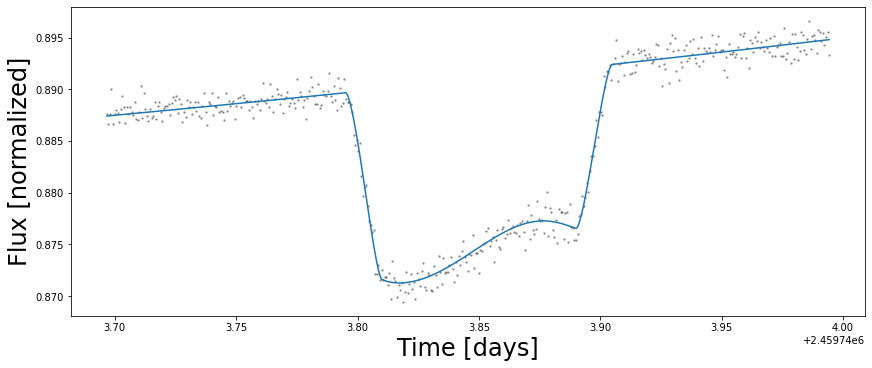

In [177]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [178]:
map_soln

{'contrast_interval__': array(0.42378943),
 'spot_radius_interval__': array(-1.6199442),
 'lat': array(0.),
 'lon': array(0.),
 'A': array(0.9989555),
 'contrast': array(0.60438967),
 'spot_radius': array(29.7382618),
 'flux_model': array([0.88741263, 0.88742653, 0.88744044, 0.88745435, 0.88746828,
        0.88748221, 0.88749615, 0.8875101 , 0.88752405, 0.88753802,
        0.88755199, 0.88756597, 0.88757996, 0.88759396, 0.88760797,
        0.88762199, 0.88763601, 0.88765004, 0.88766408, 0.88767813,
        0.88769219, 0.88770626, 0.88772033, 0.88773441, 0.8877485 ,
        0.8877626 , 0.88777671, 0.88779083, 0.88780495, 0.88781908,
        0.88783322, 0.88784737, 0.88786153, 0.8878757 , 0.88788987,
        0.88790406, 0.88791825, 0.88793245, 0.88794665, 0.88796087,
        0.88797509, 0.88798933, 0.88800357, 0.88801782, 0.88803207,
        0.88804634, 0.88806061, 0.8880749 , 0.88808919, 0.88810349,
        0.88811779, 0.88813211, 0.88814643, 0.88816077, 0.88817511,
        0.88818946, 

In [180]:
import pymc3_ext

with mod:
    trace = pymc3_ext.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=2,
        cores=1,
        target_accept=0.9,
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:109: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [A, lon, lat, spot_radius, contrast]


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 770 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNI

In [361]:
.__version__

'1.2.0'

In [181]:
import arviz as az

In [182]:
with mod:
    summary = az.summary(trace)
    
summary

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lat,1.476,1.576,-1.652,4.089,0.069,0.049,528.0,468.0,1.01
lon,1.272,1.226,-0.992,3.611,0.046,0.038,717.0,639.0,1.00
A,0.994,0.006,0.983,1.004,0.000,0.000,724.0,1053.0,1.00
contrast,0.675,0.069,0.536,0.789,0.004,0.003,253.0,93.0,1.06
spot_radius,27.578,1.690,24.369,30.546,0.093,0.067,323.0,121.0,1.04
...,...,...,...,...,...,...,...,...,...
flux_model[464],0.895,0.000,0.895,0.895,0.000,0.000,1094.0,1225.0,1.00
flux_model[465],0.895,0.000,0.895,0.895,0.000,0.000,1093.0,1225.0,1.00
flux_model[466],0.895,0.000,0.895,0.895,0.000,0.000,1093.0,1225.0,1.00
flux_model[467],0.895,0.000,0.895,0.895,0.000,0.000,1092.0,1225.0,1.00


In [183]:
# contrast=0.6, radius=30, lat=0, lon=0

In [184]:
with pm.Model() as model:

    # Primary
    recovered = starry.Primary(
        starry.Map(ydeg=hatp18_params["ydeg"], udeg=hatp18_params["udeg"], amp=hatp18_params["amp"]),
        r=hatp18_params["r"],
        m=hatp18_params["m"],
        prot=hatp18_params["prot"],
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
#     recovered.map[1:] = [summary['mean']['ld[0]'],summary['mean']['ld[1]']]
    recovered.map[1:] = hatp18_params["u"]
    
    recovered.map.spot(contrast=summary['mean']['contrast'], 
                       radius=summary['mean']['spot_radius'], 
                       lat=summary['mean']['lat'], 
                       lon=summary['mean']['lon'])
    
#     planet = starry.kepler.Secondary(
#         starry.Map(ydeg=5, amp=5e-3),  # the surface map
#         m=62.610,  # mass in solar masses
#         r=summary['mean']['radius'],  # radius in solar radii
#         porb=5.508023,  # orbital period in days
#         prot=5.508023,  # rotation period in days (synchronous)
#         inc=hatp18_params["inc"],
#     #     Omega=120,  # longitude of ascending node in degrees
#         ecc=summary['mean']['ecc'],  # eccentricity
#         omega=summary['mean']['omega'],  # longitude of pericenter in degrees
#         t0=summary['mean']['transit_epoch'],  # time of transit in days
#         length_unit=u.R_earth,
#         mass_unit=u.M_earth,
#         )

    planet = starry.kepler.Secondary(
        starry.Map(ydeg=5, amp=5e-3),  # the surface map
        m=62.610,  # mass in solar masses
        r=11.153,# radius
        inc=hatp18_params["inc"],
        length_unit=u.R_earth,
        mass_unit=u.M_earth,
        porb=5.508023,  # orbital period in days
        prot=5.508023,  # rotation period in days (synchronous)
        omega=120,  # longitude of ascending node in degrees
        ecc=0.084,  # eccentricity
        t0=2459743.85,  # time of transit in days
        )
    
    sys_recovered = starry.System(recovered, planet)
    
    # Our model for the flux
#     print(eval_in_model(pri.map.flux(theta=360*t/A["prot"])))
#     flux_model = pm.Deterministic("flux_model", sys.flux(t))

In [162]:
recovered.map.show(theta=np.linspace(0, 360, 50))

In [152]:
sys_recovered.show(t)

In [151]:
star_theory.map.show(theta=np.linspace(0, 360, 50))

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


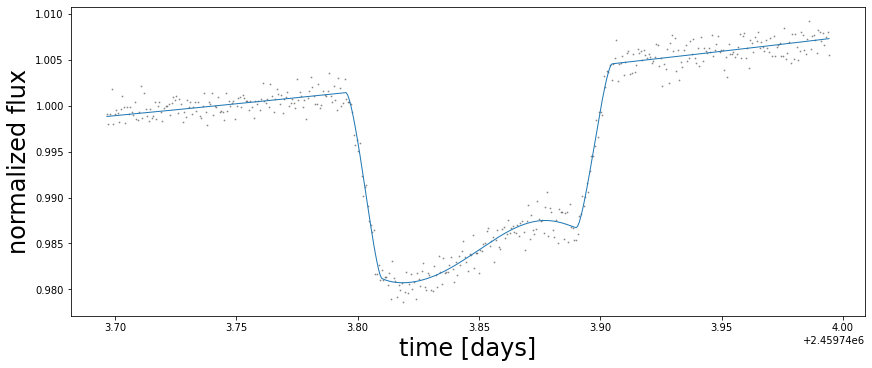

In [185]:
flux_recovered = eval_in_model(sys_recovered.flux(t), model=model)
flux_recovered = flux_recovered/np.nanmedian(flux_recovered)
# flux_true = eval_in_model(star.map.flux(theta=360*bin_hatp18b.time.to_value('d')/A["prot"]), model=model)
# sigma = 0.0001
# flux = flux_true + sigma * np.random.randn(len(t))
# ferr = sigma * np.random.randn(len(t))

fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux/np.nanmedian(flux), "k.", alpha=0.3, ms=2)
# plt.errorbar(t, flux, ferr, c="k", alpha=0.3)
ax.plot(t, flux_recovered, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

In [186]:
summary['mean']#['A']

lat                 1.476
lon                 1.272
A                   0.994
contrast            0.675
spot_radius        27.578
                    ...  
flux_model[464]     0.895
flux_model[465]     0.895
flux_model[466]     0.895
flux_model[467]     0.895
flux_model[468]     0.895
Name: mean, Length: 474, dtype: float64

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  

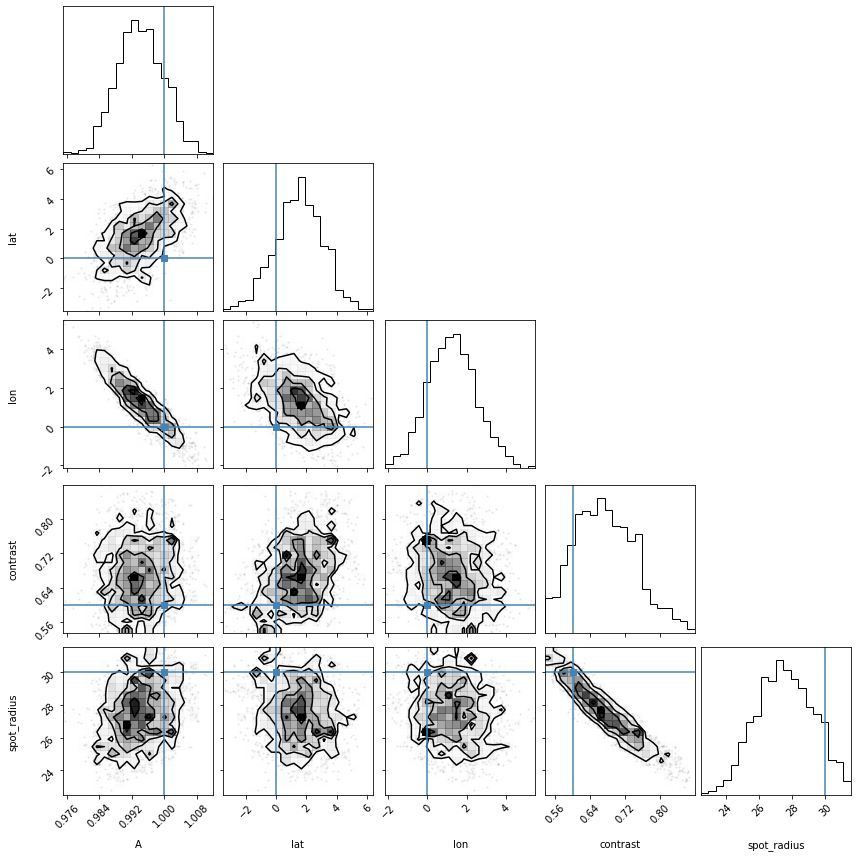

In [187]:
import corner
with mod:
    corner.corner(trace,var_names=['A','lat','lon','contrast','spot_radius'], truths=[1,0,0,0.6, 30])

In [172]:
star_theory.map.spot.

<bound method YlmBase.spot of <starry.maps.Map.<locals>.Map object at 0x7fb0ba753fd0>>